In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline


### Reading and splitting data

In [74]:
data = pd.read_csv("aqarmap_data/cleaned_housing_data.csv")
data.head(3)

,URL,Price,Rooms,Baths,Area,Lat,Lon,Floor,Finishing,Governate,Neighbourhood
0,https://aqarmap.com.eg/ar/listing/5923848-for-...,7900000,3,3,176,30.015287,30.983945,4,نصف تشطيب,القاهرة الكبرى,كمبوند تراس
1,https://aqarmap.com.eg/ar/listing/6108263-for-...,13000000,4,4,245,30.100866,31.632139,1,سوبر لوكس,القاهرة الكبرى,طريق مدينتي
2,https://aqarmap.com.eg/ar/listing/6418731-for-...,7500000,3,2,180,30.024799,31.516782,1,سوبر لوكس,القاهرة الكبرى,اللوتس الجديدة


now we Create a feature matrix X_train and target vector y_train. target is "price". our features should be all the columns except Neighbourhood and URL.

In [75]:
X_train = data.drop(columns=["Price","URL","Neighbourhood"])
y_train = data["Price"]
X_train.head()

,Rooms,Baths,Area,Lat,Lon,Floor,Finishing,Governate
0,3,3,176,30.015287,30.983945,4,نصف تشطيب,القاهرة الكبرى
1,4,4,245,30.100866,31.632139,1,سوبر لوكس,القاهرة الكبرى
2,3,2,180,30.024799,31.516782,1,سوبر لوكس,القاهرة الكبرى
3,4,3,230,30.034311,31.461851,1,اكسترا سوبر لوكس,القاهرة الكبرى
4,2,1,116,29.986745,31.319028,1,سوبر لوكس,القاهرة الكبرى


### Building the model

In [76]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
print("Mean apt price:", y_mean.round(2))

print("Baseline MAE:", mean_absolute_error(y_train,y_pred_baseline))

Mean apt price: 6447173.62
Baseline MAE: 2839399.4152118056


Create a pipeline named model that contains a OneHotEncoder and Linear regression predictor

In [77]:
numeric = ["Rooms", "Baths", "Area", "Lat", "Lon", "Floor"]
categorical = ["Finishing", "Governate"]

In [89]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
    ]
)

In [90]:
model = make_pipeline(
    preprocessor,
    LinearRegression()
)
model.fit(X_train,y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('linearregression', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers 

In [91]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train,y_pred_training))

Training MAE: 2474520.0032408806


### Communicate Results

In [92]:
intercept = model.named_steps["linearregression"].intercept_
coefficients = model.named_steps["linearregression"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 22
[1372377.51957174 -212862.88652504 -154085.55242605 -411598.47526004
 -593830.60537327]


In [93]:

feature_names = model.named_steps["columntransformer"].get_feature_names_out(X_train.columns)
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 22
['cat__Finishing_اكسترا سوبر لوكس' 'cat__Finishing_بدون تشطيب'
 'cat__Finishing_سوبر لوكس' 'cat__Finishing_لوكس'
 'cat__Finishing_نصف تشطيب']


In [94]:
feat_imp = pd.Series(coefficients,index=feature_names)
feat_imp.head()

cat__Finishing_اكسترا سوبر لوكس    1.372378e+06
cat__Finishing_بدون تشطيب         -2.128629e+05
cat__Finishing_سوبر لوكس          -1.540856e+05
cat__Finishing_لوكس               -4.115985e+05
cat__Finishing_نصف تشطيب          -5.938306e+05
dtype: float64

In [95]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 4042434.33
+ (1372377.52 * cat__Finishing_اكسترا سوبر لوكس)
+ (-212862.89 * cat__Finishing_بدون تشطيب)
+ (-154085.55 * cat__Finishing_سوبر لوكس)
+ (-411598.48 * cat__Finishing_لوكس)
+ (-593830.61 * cat__Finishing_نصف تشطيب)
+ (3162491.91 * cat__Governate_الاسكندرية)
+ (-2888353.78 * cat__Governate_الاسماعيلية)
+ (153866.09 * cat__Governate_البحر الأحمر)
+ (-288324.45 * cat__Governate_التوسعات السياحية الشمالية)
+ (3372431.82 * cat__Governate_الجيزة)
+ (726899.5 * cat__Governate_الدقهلية)
+ (3716483.04 * cat__Governate_الساحل الشمالي)
+ (-2371237.3 * cat__Governate_السويس)
+ (69116.79 * cat__Governate_الشرقية)
+ (3634783.66 * cat__Governate_العين السخنة)
+ (2969874.55 * cat__Governate_القاهرة الكبرى)
+ (-3188328.54 * cat__Governate_القليوبية)
+ (-3055887.62 * cat__Governate_المنوفية)
+ (-1468601.27 * cat__Governate_المنيا)
+ (-1638326.36 * cat__Governate_بور سعيد)
+ (-1609052.83 * cat__Governate_دمياط)
+ (-1297835.21 * cat__Governate_مرسى مطروح)


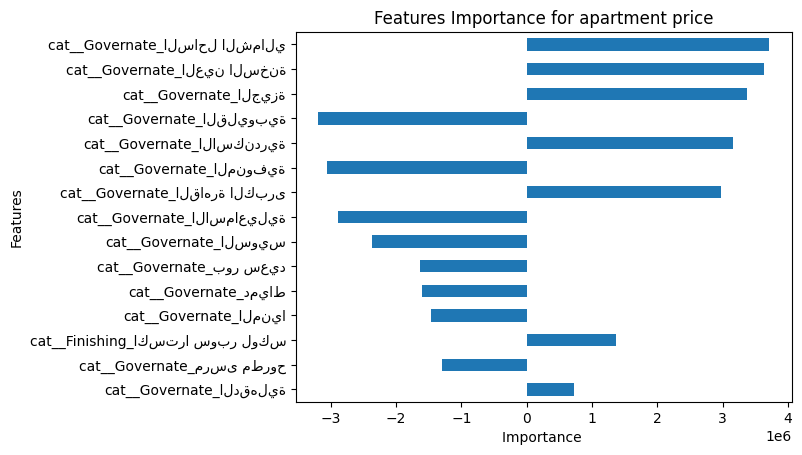

In [96]:
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance ")
plt.ylabel("Features")
plt.title("Features Importance for apartment price");

In [97]:

def make_prediction(Rooms,Baths,Area,Lat,Lon,Floor,Finishing,Governate):
    data = {"Rooms":Rooms,
            "Baths" :Baths,
            "Area":Area,
            "Lat":Lat,
            "Lon":Lon,
            "Floor":Floor,
            "Finishing":Finishing,
            "Governate":Governate
           }
    df = pd.DataFrame(data, index=[0])
    print(df)
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"
make_prediction(2,2,120,30.0444,31.2357,3,"لوكس","القاهره الكبري")

   Rooms  Baths  Area      Lat      Lon  Floor Finishing       Governate
0      2      2   120  30.0444  31.2357      3      لوكس  القاهره الكبري


'Predicted apartment price: $3630835.86'

In [99]:
interact(
    make_prediction, 
    
        # Match the argument name 'Area' from the function
    Area=IntSlider(
        min=int(X_train["Area"].min()), 
        max=int(X_train["Area"].max()), 
        value=int(X_train["Area"].mean()),
    ),
    Lat=FloatSlider(
        min=X_train["Lat"].min(), 
        max=X_train["Lat"].max(), 
        step=0.01, 
        value=X_train["Lat"].mean(),
    ),
    Lon=FloatSlider(
        min=X_train["Lon"].min(), 
        max=X_train["Lon"].max(), 
        step=0.01, 
        value=X_train["Lon"].mean(),
    ),
    # Added missing sliders for Rooms, Baths, Floor, and Finishing
    Rooms=IntSlider(min=1, max=10, step=1, value=3),
    Baths=IntSlider(min=1, max=5, step=1, value=2),
    Floor=IntSlider(min=0, max=20, step=1, value=1),
    Finishing=Dropdown(options=sorted(X_train["Finishing"].unique())),
    
    # Match 'Governate' with your function argument
    Governate=Dropdown(options=sorted(X_train["Governate"].unique()))
);

interactive(children=(IntSlider(value=3, description='Rooms', max=10, min=1), IntSlider(value=2, description='…

## saving the model

In [100]:
import joblib

# saves trained pipeline
joblib.dump(model, 'house_model.pkl')

print("Model saved successfully as house_model.pkl")

Model saved successfully as house_model.pkl
